
Best Temporal Shifts and Correlations for Each Electrode:
AF3 430 0.759
AF4 430 0.716
AFz 450 0.712
C2 720 0.555
Cz 750 0.520
C1 760 0.516
F1 680 0.496
FC3 -930 0.493
C4 710 0.487
FC2 820 0.474
FC1 -930 0.467
F2 700 0.459
F4 640 0.459
FC4 830 0.459
Fz 700 0.456
C3 750 0.450
F3 390 0.232


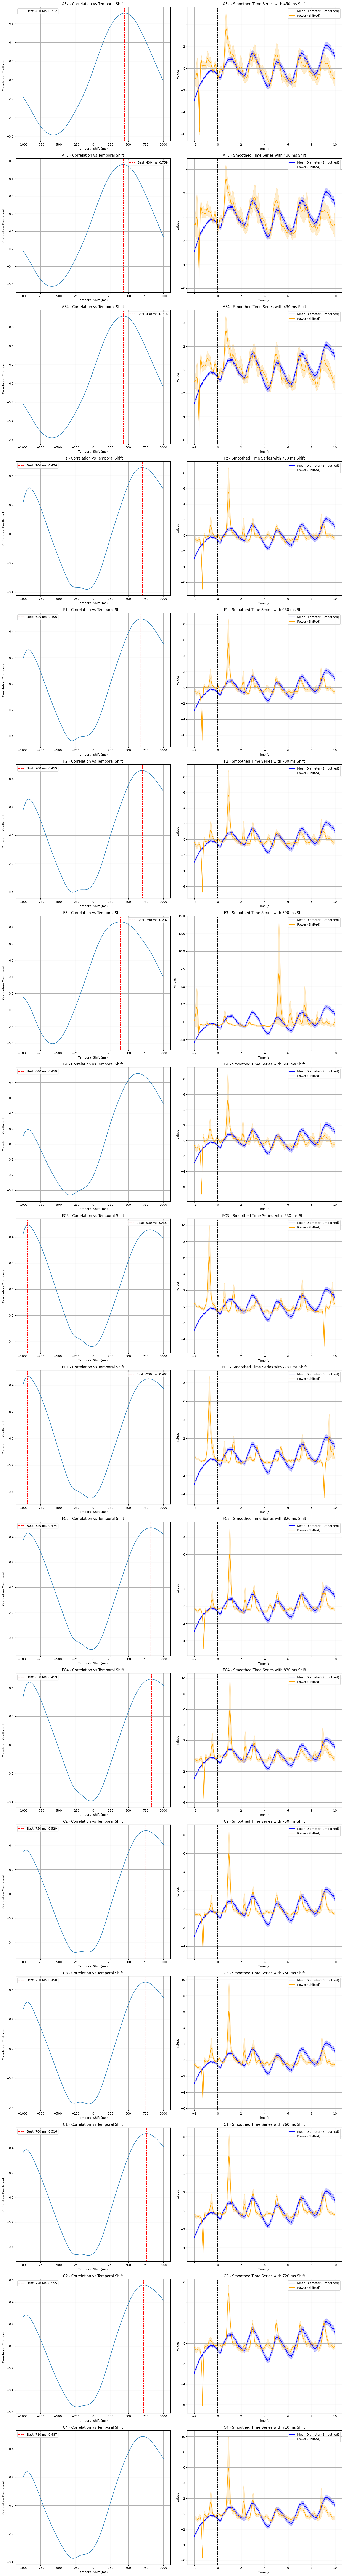

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

frontal_midline_channels = ['AFz', 'AF3', 'AF4', 'Fz', 'F1', 'F2', 'F3', 'F4', 'FC3', 'FC1', 'FC2', 'FC4', 'Cz', 'C3', 'C1', 'C2', 'C4']

# Load pupil data
pupil_data = pd.read_csv("Pupil_Processed/pupil_memory_all.csv", usecols=['Mean_Diameter', 'SEM_Diameter'])

# Normalize pupil data (z-scoring)
pupil_data['Mean_Diameter_Normalized'] = (pupil_data['Mean_Diameter'] - pupil_data['Mean_Diameter'].mean()) / pupil_data['Mean_Diameter'].std()
pupil_data['SEM_Diameter_Normalized'] = pupil_data['SEM_Diameter'] / pupil_data['Mean_Diameter'].std()

mean_diameters = pupil_data['Mean_Diameter_Normalized']
sem_diameters = pupil_data['SEM_Diameter_Normalized']

# Time range and temporal shifts settings
valid_start_index = 200  # Corresponds to 0 seconds
valid_end_index = 1100   # Corresponds to 8 seconds (exclusive)
temporal_shifts_samples = np.arange(-100, 101, 1)  # Shifting by ±100 samples

# Initialize figure for subplots
n_electrodes = len(frontal_midline_channels)
fig, axs = plt.subplots(n_electrodes, 2, figsize=(16, 7* n_electrodes))

# Initialize a list to store best results for each electrode
best_results = []

# Loop through each electrode
for idx, electrode in enumerate(frontal_midline_channels):
    # Load data for the current electrode
    theta_data = pd.read_csv("Theta_Processed/theta_results_all.csv", usecols=['Time', f'Mean_Power_Control_{electrode}', f'SEM_Power_Control_{electrode}'])

    theta_data[f'Theta_Power_Control_{electrode}'] = pd.to_numeric(theta_data[f'Mean_Power_Control_{electrode}'], errors='coerce') # why don't we do to_numeric to SEM?
    theta_data = theta_data.drop(columns=['Time'])

    # Resample: downsample the data by averaging every 10 rows
    theta_resampled = theta_data.groupby(np.arange(len(theta_data)) // 10).mean().reset_index(drop=True)
    theta_resampled['Index'] = np.arange(len(theta_resampled)) * 10  # Every 10 ms
    theta_resampled = theta_resampled[['Index', f'Theta_Power_Control_{electrode}', f'SEM_Power_Control_{electrode}']]

    # Normalize the theta power columns (z-scoring), CLARA: didnt we alreayd normalize in the preprocessing?
    theta_resampled['Power_Normalized'] = (theta_resampled[f'Theta_Power_Control_{electrode}'] - theta_resampled[f'Theta_Power_Control_{electrode}'].mean()) / theta_resampled[f'Theta_Power_Control_{electrode}'].std()
    theta_resampled['SEM_Power_Control_Normalized'] = theta_resampled[f'SEM_Power_Control_{electrode}'] / theta_resampled[f'Theta_Power_Control_{electrode}'].std()

    power = theta_resampled['Power_Normalized']

    # Initialize variables for best results tracking
    best_correlation = -np.inf
    best_temporal_shift = None
    best_window_length = None
    best_polyorder = None
    best_correlations = []

    mean_diameters_smoothed = mean_diameters # savgol_filter(mean_diameters, window_length, polyorder)
    power_smoothed = power #savgol_filter(power, window_length, polyorder)

    correlations = []
    for shift_samples in temporal_shifts_samples:
        power_shifted = np.roll(power_smoothed, shift_samples)
        mean_diameters_window = mean_diameters_smoothed[valid_start_index:valid_end_index]
        power_shifted_window = power_shifted[valid_start_index:valid_end_index]

        correlation = np.corrcoef(mean_diameters_window, power_shifted_window)[0, 1]
        correlations.append(correlation)

        if correlation > best_correlation:
            best_correlation = correlation
            best_temporal_shift = shift_samples * 10

    best_correlations.append((temporal_shifts_samples * 10, correlations))

    # Plot the correlation curve for this electrode
    for shifts, corrs in best_correlations:
        axs[idx, 0].plot(shifts, corrs)
    axs[idx, 0].axvline(0, color='k', linestyle='--')
    axs[idx, 0].axvline(best_temporal_shift, color='r', linestyle='--', label=f'Best: {best_temporal_shift} ms, {best_correlation:.3f}')
    axs[idx, 0].set_xlabel('Temporal Shift (ms)')
    axs[idx, 0].set_ylabel('Correlation Coefficient')
    axs[idx, 0].set_title(f'{electrode} - Correlation vs Temporal Shift')
    axs[idx, 0].grid(True)
    axs[idx, 0].legend()

    # Smoothing for the best correlation parameters
    mean_diameters_smoothed = mean_diameters # savgol_filter(mean_diameters, best_window_length, best_polyorder)
    sem_diameters_smoothed = sem_diameters # savgol_filter(sem_diameters, best_window_length, best_polyorder)

    power_smoothed = power # savgol_filter(power, best_window_length, best_polyorder)
    sem_power_smoothed = theta_resampled['SEM_Power_Control_Normalized'] # savgol_filter(theta_resampled['SEM_Power_Control_Normalized'], best_window_length, best_polyorder)

    power_shifted = np.roll(power_smoothed, int(best_temporal_shift / 10))
    sem_power_shifted = np.roll(sem_power_smoothed, int(best_temporal_shift / 10))

    min_len = min(len(mean_diameters_smoothed), len(power_shifted))

    mean_diameters_smoothed = mean_diameters_smoothed[:min_len]
    power_shifted = power_shifted[:min_len]
    sem_diameters_smoothed = sem_diameters_smoothed[:min_len]
    sem_power_shifted = sem_power_shifted[:min_len]

    # Adjust time_axis to match the shifted power length
    time_axis = np.arange(min_len) * 0.01 - 2

    # Plot the smoothed time series and shift for this electrode
    axs[idx, 1].plot(time_axis, mean_diameters_smoothed, color='b', label='Mean Diameter (Smoothed)')
    axs[idx, 1].fill_between(time_axis, mean_diameters_smoothed - sem_diameters_smoothed, 
                             mean_diameters_smoothed + sem_diameters_smoothed, color='b', alpha=0.2)
    axs[idx, 1].plot(time_axis, power_shifted, color='orange', label='Power (Shifted)')
    axs[idx, 1].fill_between(time_axis, power_shifted - sem_power_shifted, power_shifted + sem_power_shifted, color='orange', alpha=0.2)
    axs[idx, 1].set_xlabel('Time (s)')
    axs[idx, 1].set_ylabel('Values')
    axs[idx, 1].set_title(f'{electrode} - Smoothed Time Series with {best_temporal_shift} ms Shift')
    axs[idx, 1].axvline(0, color='k', linestyle='--')
    axs[idx, 1].legend()
    axs[idx, 1].grid(True)

    # Append the best results for the current electrode to the list
    best_results.append((electrode, best_temporal_shift, best_correlation))

# Adjust layout to prevent overlap
plt.tight_layout()
# plt.show()

# Sort results by correlation descending and print
best_results_sorted = sorted(best_results, key=lambda x: abs(x[2]), reverse=True)

print("\nBest Temporal Shifts and Correlations for Each Electrode:")
for electrode, shift, correlation in best_results_sorted:
    print(f"{electrode} {shift} {correlation:.3f}")



Best Temporal Shifts and Correlations for Each Electrode:
AFz 390 0.847
AF3 390 0.845
AF4 390 0.840
F3 460 0.830
F1 510 0.817
Fz 520 0.813
F2 500 0.807
F4 440 0.805
C2 640 0.670
C3 590 0.638
C4 550 0.635
C1 650 0.630
Cz 660 0.607
FC1 800 0.526
FC2 750 0.520
FC3 670 0.511
FC4 680 0.417


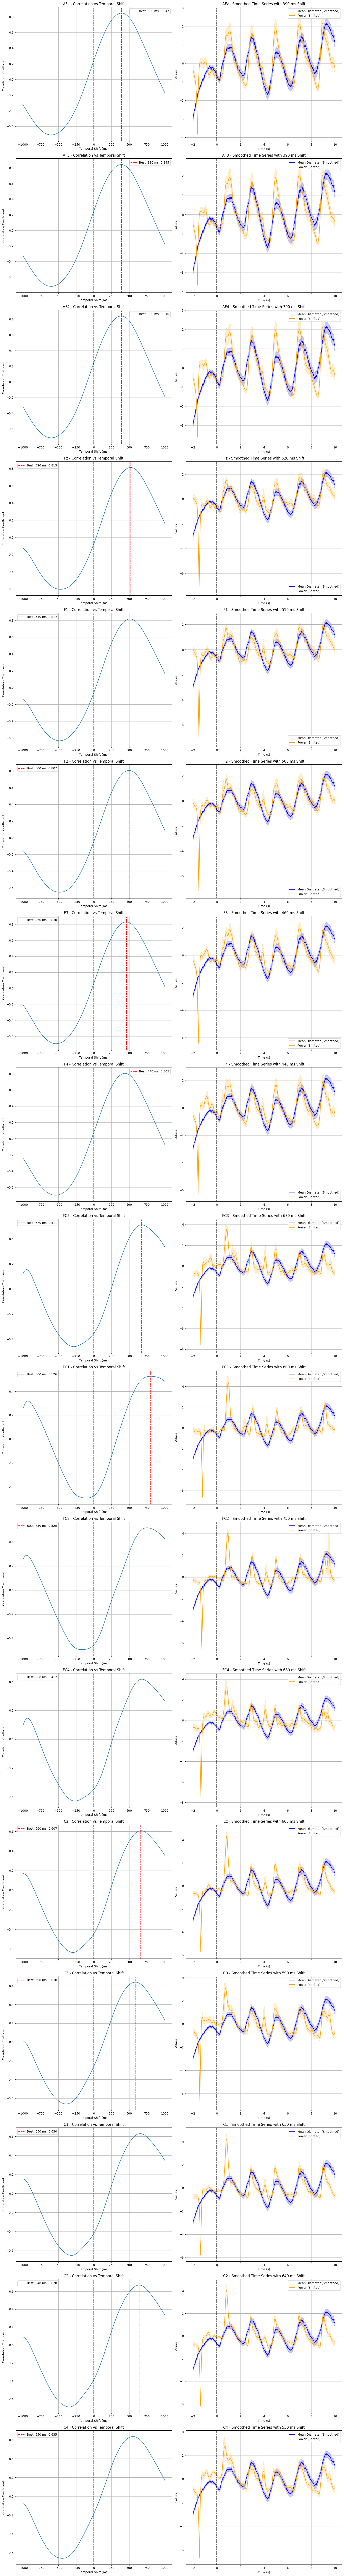

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

frontal_midline_channels = ['AFz', 'AF3', 'AF4', 'Fz', 'F1', 'F2', 'F3', 'F4', 'FC3', 'FC1', 'FC2', 'FC4', 'Cz', 'C3', 'C1', 'C2', 'C4']

# Load pupil data
pupil_data = pd.read_csv("Pupil_Processed/pupil_memory_all.csv", usecols=['Mean_Diameter', 'SEM_Diameter'])

# Normalize pupil data (z-scoring)
pupil_data['Mean_Diameter_Normalized'] = (pupil_data['Mean_Diameter'] - pupil_data['Mean_Diameter'].mean()) / pupil_data['Mean_Diameter'].std()
pupil_data['SEM_Diameter_Normalized'] = pupil_data['SEM_Diameter'] / pupil_data['Mean_Diameter'].std()

mean_diameters = pupil_data['Mean_Diameter_Normalized']
sem_diameters = pupil_data['SEM_Diameter_Normalized']

# Time range and temporal shifts settings
valid_start_index = 200  # Corresponds to 0 seconds
valid_end_index = 1100   # Corresponds to 8 seconds (exclusive)
temporal_shifts_samples = np.arange(-100, 101, 1)  # Shifting by ±100 samples

# Initialize figure for subplots
n_electrodes = len(frontal_midline_channels)
fig, axs = plt.subplots(n_electrodes, 2, figsize=(16, 7* n_electrodes))

# Initialize a list to store best results for each electrode
best_results = []

# Loop through each electrode
for idx, electrode in enumerate(frontal_midline_channels):
    # Load data for the current electrode
    theta_data = pd.read_csv("Theta_Processed/theta_results_all.csv", usecols=['Time', f'Mean_Power_Memory_{electrode}', f'SEM_Power_Memory_{electrode}'])

    theta_data[f'Theta_Power_Memory_{electrode}'] = pd.to_numeric(theta_data[f'Mean_Power_Memory_{electrode}'], errors='coerce')
    theta_data = theta_data.drop(columns=['Time'])

    # Resample: downsample the data by averaging every 10 rows
    theta_resampled = theta_data.groupby(np.arange(len(theta_data)) // 10).mean().reset_index(drop=True)
    theta_resampled['Index'] = np.arange(len(theta_resampled)) * 10  # Every 10 ms
    theta_resampled = theta_resampled[['Index', f'Theta_Power_Memory_{electrode}', f'SEM_Power_Memory_{electrode}']]

    # Normalize the theta power columns (z-scoring)
    theta_resampled['Power_Normalized'] = (theta_resampled[f'Theta_Power_Memory_{electrode}'] - theta_resampled[f'Theta_Power_Memory_{electrode}'].mean()) / theta_resampled[f'Theta_Power_Memory_{electrode}'].std()
    theta_resampled['SEM_Power_Memory_Normalized'] = theta_resampled[f'SEM_Power_Memory_{electrode}'] / theta_resampled[f'Theta_Power_Memory_{electrode}'].std()

    power = theta_resampled['Power_Normalized']

    # Initialize variables for best results tracking
    best_correlation = -np.inf
    best_temporal_shift = None
    best_window_length = None
    best_polyorder = None
    best_correlations = []

    mean_diameters_smoothed = mean_diameters # savgol_filter(mean_diameters, window_length, polyorder)
    power_smoothed = power #savgol_filter(power, window_length, polyorder)

    correlations = []
    for shift_samples in temporal_shifts_samples:
        power_shifted = np.roll(power_smoothed, shift_samples)
        mean_diameters_window = mean_diameters_smoothed[valid_start_index:valid_end_index]
        power_shifted_window = power_shifted[valid_start_index:valid_end_index]

        correlation = np.corrcoef(mean_diameters_window, power_shifted_window)[0, 1]
        correlations.append(correlation)

        if correlation > best_correlation:
            best_correlation = correlation
            best_temporal_shift = shift_samples * 10

    best_correlations.append((temporal_shifts_samples * 10, correlations))

    # Plot the correlation curve for this electrode
    for shifts, corrs in best_correlations:
        axs[idx, 0].plot(shifts, corrs)
    axs[idx, 0].axvline(0, color='k', linestyle='--')
    axs[idx, 0].axvline(best_temporal_shift, color='r', linestyle='--', label=f'Best: {best_temporal_shift} ms, {best_correlation:.3f}')
    axs[idx, 0].set_xlabel('Temporal Shift (ms)')
    axs[idx, 0].set_ylabel('Correlation Coefficient')
    axs[idx, 0].set_title(f'{electrode} - Correlation vs Temporal Shift')
    axs[idx, 0].grid(True)
    axs[idx, 0].legend()

    # Smoothing for the best correlation parameters
    mean_diameters_smoothed = mean_diameters # savgol_filter(mean_diameters, best_window_length, best_polyorder)
    sem_diameters_smoothed = sem_diameters # savgol_filter(sem_diameters, best_window_length, best_polyorder)

    power_smoothed = power # savgol_filter(power, best_window_length, best_polyorder)
    sem_power_smoothed = theta_resampled['SEM_Power_Memory_Normalized'] # savgol_filter(theta_resampled['SEM_Power_Control_Normalized'], best_window_length, best_polyorder)

    power_shifted = np.roll(power_smoothed, int(best_temporal_shift / 10))
    sem_power_shifted = np.roll(sem_power_smoothed, int(best_temporal_shift / 10))

    min_len = min(len(mean_diameters_smoothed), len(power_shifted))

    mean_diameters_smoothed = mean_diameters_smoothed[:min_len]
    power_shifted = power_shifted[:min_len]
    sem_diameters_smoothed = sem_diameters_smoothed[:min_len]
    sem_power_shifted = sem_power_shifted[:min_len]

    # Adjust time_axis to match the shifted power length
    time_axis = np.arange(min_len) * 0.01 - 2

    # Plot the smoothed time series and shift for this electrode
    axs[idx, 1].plot(time_axis, mean_diameters_smoothed, color='b', label='Mean Diameter (Smoothed)')
    axs[idx, 1].fill_between(time_axis, mean_diameters_smoothed - sem_diameters_smoothed, 
                             mean_diameters_smoothed + sem_diameters_smoothed, color='b', alpha=0.2)
    axs[idx, 1].plot(time_axis, power_shifted, color='orange', label='Power (Shifted)')
    axs[idx, 1].fill_between(time_axis, power_shifted - sem_power_shifted, power_shifted + sem_power_shifted, color='orange', alpha=0.2)
    axs[idx, 1].set_xlabel('Time (s)')
    axs[idx, 1].set_ylabel('Values')
    axs[idx, 1].set_title(f'{electrode} - Smoothed Time Series with {best_temporal_shift} ms Shift')
    axs[idx, 1].axvline(0, color='k', linestyle='--')
    axs[idx, 1].legend()
    axs[idx, 1].grid(True)

    # Append the best results for the current electrode to the list
    best_results.append((electrode, best_temporal_shift, best_correlation))

# Adjust layout to prevent overlap
plt.tight_layout()
# plt.show()

# Sort results by correlation descending and print
best_results_sorted = sorted(best_results, key=lambda x: abs(x[2]), reverse=True)

print("\nBest Temporal Shifts and Correlations for Each Electrode:")
for electrode, shift, correlation in best_results_sorted:
    print(f"{electrode} {shift} {correlation:.3f}")


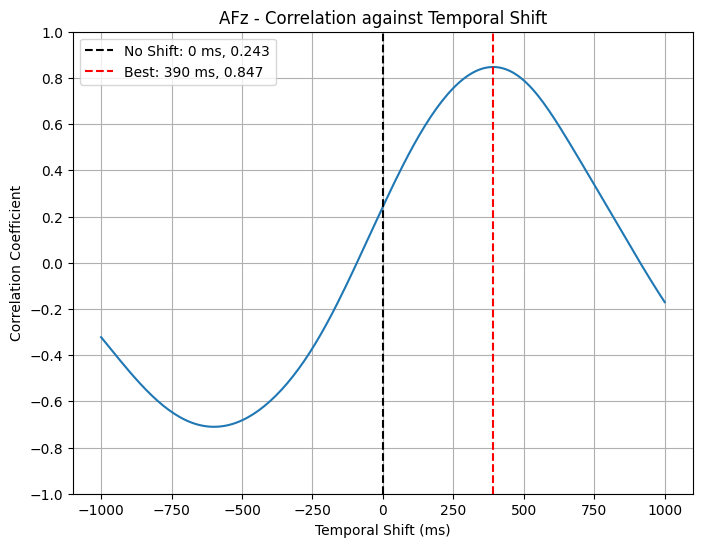

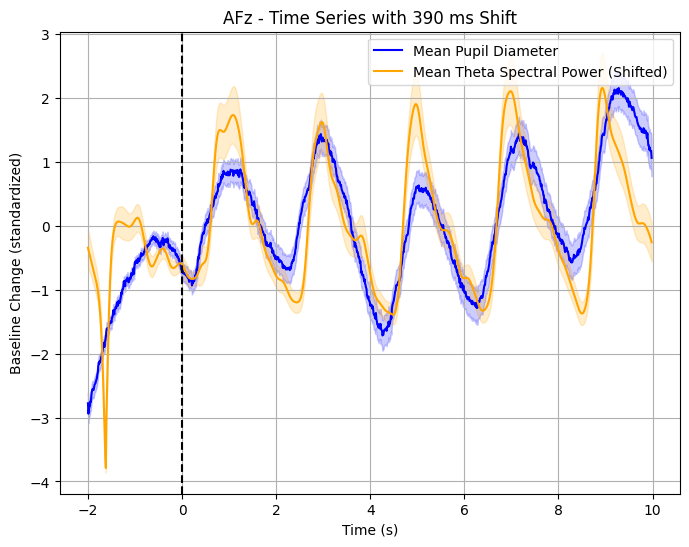


Best Temporal Shift and Correlation for AFz:
390 ms, 0.847


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Define the single electrode
electrode = 'AFz'

# Load pupil data
pupil_data = pd.read_csv("Pupil_Processed/pupil_memory_all.csv", usecols=['Mean_Diameter', 'SEM_Diameter'])

# Normalize pupil data (z-scoring)
pupil_data['Mean_Diameter_Normalized'] = (pupil_data['Mean_Diameter'] - pupil_data['Mean_Diameter'].mean()) / pupil_data['Mean_Diameter'].std()
pupil_data['SEM_Diameter_Normalized'] = pupil_data['SEM_Diameter'] / pupil_data['Mean_Diameter'].std()

mean_diameters = pupil_data['Mean_Diameter_Normalized']
sem_diameters = pupil_data['SEM_Diameter_Normalized']

# Time range and temporal shifts settings
valid_start_index = 200  # Corresponds to 0 seconds
valid_end_index = 1100   # Corresponds to 8 seconds (exclusive)
temporal_shifts_samples = np.arange(-100, 101, 1)  # Shifting by ±100 samples

# Load data for the selected electrode
theta_data = pd.read_csv("Theta_Processed/theta_results_all.csv", usecols=['Time', f'Mean_Power_Memory_{electrode}', f'SEM_Power_Memory_{electrode}'])

theta_data[f'Theta_Power_Memory_{electrode}'] = pd.to_numeric(theta_data[f'Mean_Power_Memory_{electrode}'], errors='coerce')
theta_data = theta_data.drop(columns=['Time'])

# Resample: downsample the data by averaging every 10 rows
theta_resampled = theta_data.groupby(np.arange(len(theta_data)) // 10).mean().reset_index(drop=True)
theta_resampled['Index'] = np.arange(len(theta_resampled)) * 10  # Every 10 ms
theta_resampled = theta_resampled[['Index', f'Theta_Power_Memory_{electrode}', f'SEM_Power_Memory_{electrode}']]

# Normalize the theta power columns (z-scoring)
theta_resampled['Power_Normalized'] = (theta_resampled[f'Theta_Power_Memory_{electrode}'] - theta_resampled[f'Theta_Power_Memory_{electrode}'].mean()) / theta_resampled[f'Theta_Power_Memory_{electrode}'].std()
theta_resampled['SEM_Power_Memory_Normalized'] = theta_resampled[f'SEM_Power_Memory_{electrode}'] / theta_resampled[f'Theta_Power_Memory_{electrode}'].std()

power = theta_resampled['Power_Normalized']

# Initialize variables for best results tracking
best_correlation = 0
best_temporal_shift = None

correlations = []
for shift_samples in temporal_shifts_samples:
    power_shifted = np.roll(power, shift_samples)
    mean_diameters_window = mean_diameters[valid_start_index:valid_end_index]
    power_shifted_window = power_shifted[valid_start_index:valid_end_index]

    correlation = np.corrcoef(mean_diameters_window, power_shifted_window)[0, 1]
    correlations.append(correlation)

    if abs(correlation) > abs(best_correlation):
        best_correlation = correlation
        best_temporal_shift = shift_samples * 10

# First Plot: Correlation curve
plt.figure(figsize=(8, 6))
plt.plot(temporal_shifts_samples * 10, correlations)
plt.axvline(0, color='k', linestyle='--', label=f'No Shift: 0 ms, {correlations[100]:.3f}')  # No shift correlation
plt.axvline(best_temporal_shift, color='r', linestyle='--', label=f'Best: {best_temporal_shift} ms, {best_correlation:.3f}')  # Best shift correlation
plt.xlabel('Temporal Shift (ms)')
plt.ylabel('Correlation Coefficient')
plt.yticks(np.arange(-1, 1.1, 0.2))
plt.xticks(np.arange(-1000, 1001, 250))
plt.title(f'{electrode} - Correlation against Temporal Shift')
plt.grid(True)
plt.legend()
plt.show()  # Display the first plot

# Smoothing for the best correlation parameters
mean_diameters_smoothed = mean_diameters
sem_diameters_smoothed = sem_diameters

power_smoothed = power
sem_power_smoothed = theta_resampled['SEM_Power_Memory_Normalized']

power_shifted = np.roll(power_smoothed, int(best_temporal_shift / 10))
sem_power_shifted = np.roll(sem_power_smoothed, int(best_temporal_shift / 10))

min_len = min(len(mean_diameters_smoothed), len(power_shifted))

mean_diameters_smoothed = mean_diameters_smoothed[:min_len]
power_shifted = power_shifted[:min_len]
sem_diameters_smoothed = sem_diameters_smoothed[:min_len]
sem_power_shifted = sem_power_shifted[:min_len]

# Adjust time_axis to match the shifted power length
time_axis = np.arange(min_len) * 0.01 - 2

# Second Plot: Time series with shift
plt.figure(figsize=(8, 6))
plt.plot(time_axis, mean_diameters_smoothed, color='b', label='Mean Pupil Diameter')
plt.fill_between(time_axis, mean_diameters_smoothed - sem_diameters_smoothed, 
                 mean_diameters_smoothed + sem_diameters_smoothed, color='b', alpha=0.2)
plt.plot(time_axis, power_shifted, color='orange', label='Mean Theta Spectral Power (Shifted)')
plt.fill_between(time_axis, power_shifted - sem_power_shifted, power_shifted + sem_power_shifted, color='orange', alpha=0.2)
plt.xlabel('Time (s)')
plt.ylabel('Baseline Change (standardized)')
plt.title(f'{electrode} - Time Series with {best_temporal_shift} ms Shift')
plt.axvline(0, color='k', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()  # Display the second plot

# Print the best result
print(f"\nBest Temporal Shift and Correlation for {electrode}:")
print(f"{best_temporal_shift} ms, {best_correlation:.3f}")


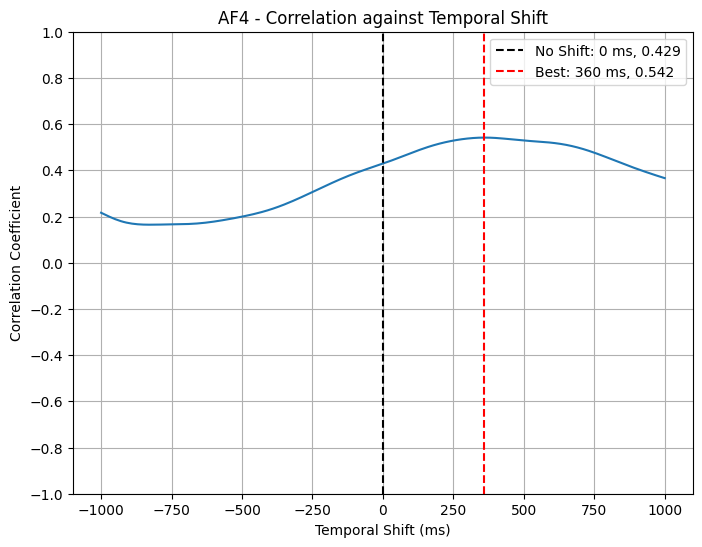

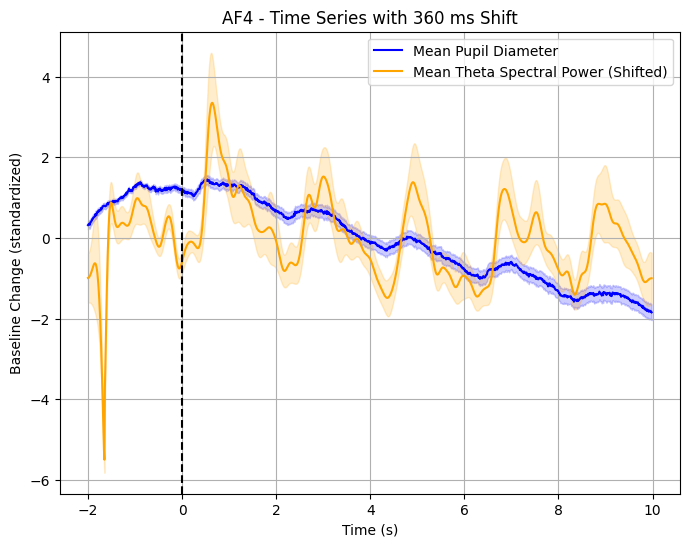


Best Temporal Shift and Correlation for AF4:
360 ms, 0.542


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Define the single electrode
electrode = 'AF4'

# Load pupil data
pupil_data = pd.read_csv("Pupil_Processed/pupil_control_all.csv", usecols=['Mean_Diameter', 'SEM_Diameter'])

# Normalize pupil data (z-scoring)
pupil_data['Mean_Diameter_Normalized'] = (pupil_data['Mean_Diameter'] - pupil_data['Mean_Diameter'].mean()) / pupil_data['Mean_Diameter'].std()
pupil_data['SEM_Diameter_Normalized'] = pupil_data['SEM_Diameter'] / pupil_data['Mean_Diameter'].std()

mean_diameters = pupil_data['Mean_Diameter_Normalized']
sem_diameters = pupil_data['SEM_Diameter_Normalized']

# Time range and temporal shifts settings
valid_start_index = 200  # Corresponds to 0 seconds
valid_end_index = 1100   # Corresponds to 8 seconds (exclusive)
temporal_shifts_samples = np.arange(-100, 101, 1)  # Shifting by ±100 samples

# Load data for the selected electrode
theta_data = pd.read_csv("Theta_Processed/theta_results_all.csv", usecols=['Time', f'Mean_Power_Control_{electrode}', f'SEM_Power_Control_{electrode}'])

theta_data[f'Theta_Power_Control_{electrode}'] = pd.to_numeric(theta_data[f'Mean_Power_Control_{electrode}'], errors='coerce')
theta_data = theta_data.drop(columns=['Time'])

# Resample: downsample the data by averaging every 10 rows
theta_resampled = theta_data.groupby(np.arange(len(theta_data)) // 10).mean().reset_index(drop=True)
theta_resampled['Index'] = np.arange(len(theta_resampled)) * 10  # Every 10 ms
theta_resampled = theta_resampled[['Index', f'Theta_Power_Control_{electrode}', f'SEM_Power_Control_{electrode}']]

# Normalize the theta power columns (z-scoring)
theta_resampled['Power_Normalized'] = (theta_resampled[f'Theta_Power_Control_{electrode}'] - theta_resampled[f'Theta_Power_Control_{electrode}'].mean()) / theta_resampled[f'Theta_Power_Control_{electrode}'].std()
theta_resampled['SEM_Power_Control_Normalized'] = theta_resampled[f'SEM_Power_Control_{electrode}'] / theta_resampled[f'Theta_Power_Control_{electrode}'].std()

power = theta_resampled['Power_Normalized']

# Initialize variables for best results tracking
best_correlation = 0
best_temporal_shift = None

correlations = []
for shift_samples in temporal_shifts_samples:
    power_shifted = np.roll(power, shift_samples)
    mean_diameters_window = mean_diameters[valid_start_index:valid_end_index]
    power_shifted_window = power_shifted[valid_start_index:valid_end_index]

    correlation = np.corrcoef(mean_diameters_window, power_shifted_window)[0, 1]
    correlations.append(correlation)

    if abs(correlation) > abs(best_correlation):
        best_correlation = correlation
        best_temporal_shift = shift_samples * 10

# First Plot: Correlation curve
plt.figure(figsize=(8, 6))
plt.plot(temporal_shifts_samples * 10, correlations)
plt.axvline(0, color='k', linestyle='--', label=f'No Shift: 0 ms, {correlations[100]:.3f}')  # No shift correlation
plt.axvline(best_temporal_shift, color='r', linestyle='--', label=f'Best: {best_temporal_shift} ms, {best_correlation:.3f}')  # Best shift correlation
plt.xlabel('Temporal Shift (ms)')
plt.ylabel('Correlation Coefficient')
plt.yticks(np.arange(-1, 1.1, 0.2))
plt.xticks(np.arange(-1000, 1001, 250))
plt.title(f'{electrode} - Correlation against Temporal Shift')
plt.grid(True)
plt.legend()
plt.show()  # Display the first plot

# Smoothing for the best correlation parameters
mean_diameters_smoothed = mean_diameters
sem_diameters_smoothed = sem_diameters

power_smoothed = power
sem_power_smoothed = theta_resampled['SEM_Power_Control_Normalized']

power_shifted = np.roll(power_smoothed, int(best_temporal_shift / 10))
sem_power_shifted = np.roll(sem_power_smoothed, int(best_temporal_shift / 10))

min_len = min(len(mean_diameters_smoothed), len(power_shifted))

mean_diameters_smoothed = mean_diameters_smoothed[:min_len]
power_shifted = power_shifted[:min_len]
sem_diameters_smoothed = sem_diameters_smoothed[:min_len]
sem_power_shifted = sem_power_shifted[:min_len]

# Adjust time_axis to match the shifted power length
time_axis = np.arange(min_len) * 0.01 - 2

# Second Plot: Time series with shift
plt.figure(figsize=(8, 6))
plt.plot(time_axis, mean_diameters_smoothed, color='b', label='Mean Pupil Diameter')
plt.fill_between(time_axis, mean_diameters_smoothed - sem_diameters_smoothed, 
                 mean_diameters_smoothed + sem_diameters_smoothed, color='b', alpha=0.2)
plt.plot(time_axis, power_shifted, color='orange', label='Mean Theta Spectral Power (Shifted)')
plt.fill_between(time_axis, power_shifted - sem_power_shifted, power_shifted + sem_power_shifted, color='orange', alpha=0.2)
plt.xlabel('Time (s)')
plt.ylabel('Baseline Change (standardized)')
plt.title(f'{electrode} - Time Series with {best_temporal_shift} ms Shift')
plt.axvline(0, color='k', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()  # Display the second plot

# Print the best result
print(f"\nBest Temporal Shift and Correlation for {electrode}:")
print(f"{best_temporal_shift} ms, {best_correlation:.3f}")
